In [ ]:
# 📌 Step 1: Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')  # Mount your Google Drive (if needed)

Mounted at /content/drive


In [ ]:
# 📌 Step 2: Upload Features and Target Data
from google.colab import files

print("🔹 Upload the Feature Data (X)...")
uploaded_X = files.upload()  # Upload AM_ML.csv or Synthetic_AM_ML.csv

print("🔹 Upload the Target Data (Y)...")
uploaded_Y = files.upload()  # Upload Target.csv (values like bead height, hardness, etc.)

🔹 Upload the Feature Data (X)...


Saving Features_AM.csv to Features_AM.csv
🔹 Upload the Target Data (Y)...


Saving Targets_AM1.csv to Targets_AM1.csv


In [ ]:
# 📌 Step 3: Import Libraries
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# 📌 Step 4: Load Data
features_df = pd.read_csv("Features_AM.csv")  # Ensure you uploaded the file
targets_df = pd.read_csv("Targets_AM1.csv")

print("Features Data Shape:", features_df.shape)
print(features_df.head())

print("\nTargets Data Shape:", targets_df.shape)
print(targets_df.head())

Features Data Shape: (9, 8)
   Scan Speed (mm/s)  Laser Power (W)  Cooling Rate ( deg.C/s)  \
0              13.33             1400                   401.08   
1              20.00             1400                   669.61   
2              26.66             1400                   834.54   
3              13.33             1600                   326.72   
4              20.00             1600                   536.75   

   Bead Width (mm)  Bead Height (mm)  No. of layers   \
0             3.02             0.907             NaN   
1             2.85             0.558             NaN   
2             2.82             0.372             NaN   
3             3.24             1.095             NaN   
4             3.11             0.670             NaN   

   Linear Heat Input (J/mm)  Thermal Cycle max temp (  deg.C)  
0                    105.03                            1425.6  
1                     70.00                            1300.9  
2                     52.51                   

In [ ]:
# 📌 Step 4: Ensure Data Consistency
X = features_df
Y = targets_df

if X.shape[0] != Y.shape[0]:
    raise ValueError("❌ ERROR: Number of rows in X and Y must match!")

In [ ]:
# 📌 Step 5: Data Preprocessing
# Fill missing values (if any)
features_df.fillna(method='ffill', inplace=True)
targets_df.fillna(method='ffill', inplace=True)

<ipython-input-8-be8c4ed0c7ea>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df.fillna(method='ffill', inplace=True)
<ipython-input-8-be8c4ed0c7ea>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  targets_df.fillna(method='ffill', inplace=True)


In [ ]:
# 📌 Step 5: Split Data (80% Training, 20% Testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("\n🔹 Training Data Shape:", X_train.shape, Y_train.shape)
print("🔹 Testing Data Shape:",X_test.shape, Y_test.shape)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🔹 Training Data Shape: (7, 8) (7, 3)
🔹 Testing Data Shape: (2, 8) (2, 3)


In [ ]:
# 📌 Step 6: Generate Synthetic Data (Interpolation)
new_scan_speeds = np.linspace(features_df['Scan Speed (mm/s)'].min(), features_df['Scan Speed (mm/s)'].max(), 15)
new_laser_powers = np.linspace(features_df['Laser Power (W)'].min(), features_df['Laser Power (W)'].max(), 15)

# Linear Interpolation of Cooling Rate
interp_func = interp1d(features_df['Scan Speed (mm/s)'], features_df['Cooling Rate ( deg.C/s)'], kind='linear', fill_value="extrapolate")
new_cooling_rates = interp_func(new_scan_speeds)

# Create New DataFrame
synthetic_df = pd.DataFrame({
    'Scan Speed (mm/s)': np.tile(new_scan_speeds, len(new_laser_powers)),
    'Laser Power (W)': np.repeat(new_laser_powers, len(new_scan_speeds)),
    'Cooling Rate (deg.C/s)': np.tile(new_cooling_rates, len(new_laser_powers))
})

/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [ ]:
# 📌 Step 7: Save Synthetic Dataset
synthetic_df.to_csv("Synthetic_AM_ML.csv", index=False)
print("\n🔹 Synthetic Dataset Saved as 'Synthetic_AM_ML.csv'")
print(synthetic_df.head())


🔹 Synthetic Dataset Saved as 'Synthetic_AM_ML.csv'
   Scan Speed (mm/s)  Laser Power (W)  Cooling Rate (deg.C/s)
0          13.330000           1400.0                     NaN
1          14.282143           1400.0              427.179715
2          15.234286           1400.0              467.549430
3          16.186429           1400.0              507.919145
4          17.138571           1400.0              548.288861


In [ ]:
# 📌 Step 8: Load & Verify the New Dataset
df_new = pd.read_csv("Synthetic_AM_ML.csv")
print("Expanded Data Shape:", df_new.shape)

Expanded Data Shape: (225, 3)


In [ ]:
# 📌 Step 9:Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model.fit(X_train_scaled, Y_train)

# Predict on test data
Y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared
r2 = r2_score(Y_test, Y_pred, force_finite=True)  # Use Y_pred instead of predictions
print("R² Score:", r2)

R² Score: -0.4913165615459188


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, Y_train)

print("Best Parameters:", grid_search.best_params_)

In [ ]:
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Train set size: 7 samples
Test set size: 2 samples


In [ ]:
print("Y_test values:", Y_test.values)

Y_test values: [[ 252. 1800.   20.]
 [ 309. 1400.   20.]]


In [ ]:
# 📌 Step 10: Evaluate Model Performance
# Compute error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("\n🔹 Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


🔹 Model Performance Metrics:
Mean Squared Error (MSE): 5671.9072
Mean Absolute Error (MAE): 54.3430
R² Score: -0.4374


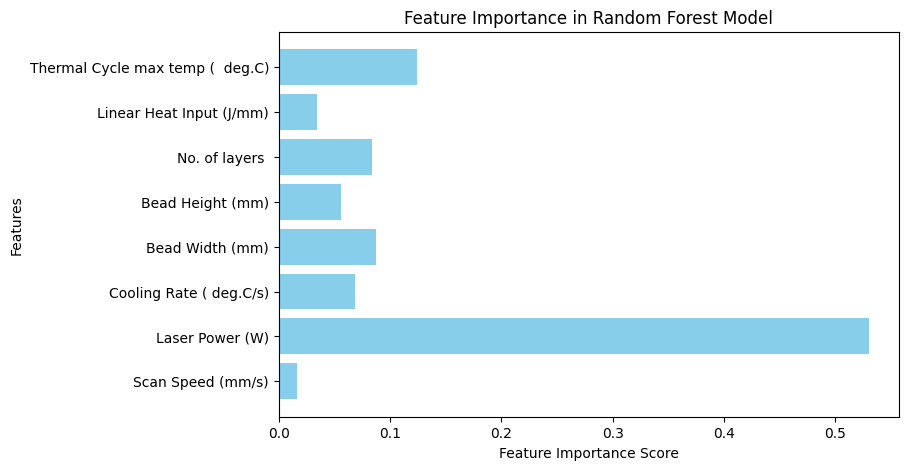

In [ ]:
# 📌 Step 11: Get feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

In [ ]:
#📌 Step 12: Save the Trained Model
import joblib
joblib.dump(rf_model, "random_forest_model.pkl")
print("\n✅ Model Saved as 'random_forest_model.pkl'")


✅ Model Saved as 'random_forest_model.pkl'


Scan Speed (mm/s)                   0
Laser Power (W)                     0
Cooling Rate ( deg.C/s)             0
Bead Width (mm)                     0
Bead Height (mm)                    0
No. of layers                       5
Linear Heat Input (J/mm)            0
Thermal Cycle max temp (  deg.C)    0
dtype: int64
Average Hardness (HV0.05)    0
Laser power (W)              0
Scan Speed (mm/s)            0
dtype: int64


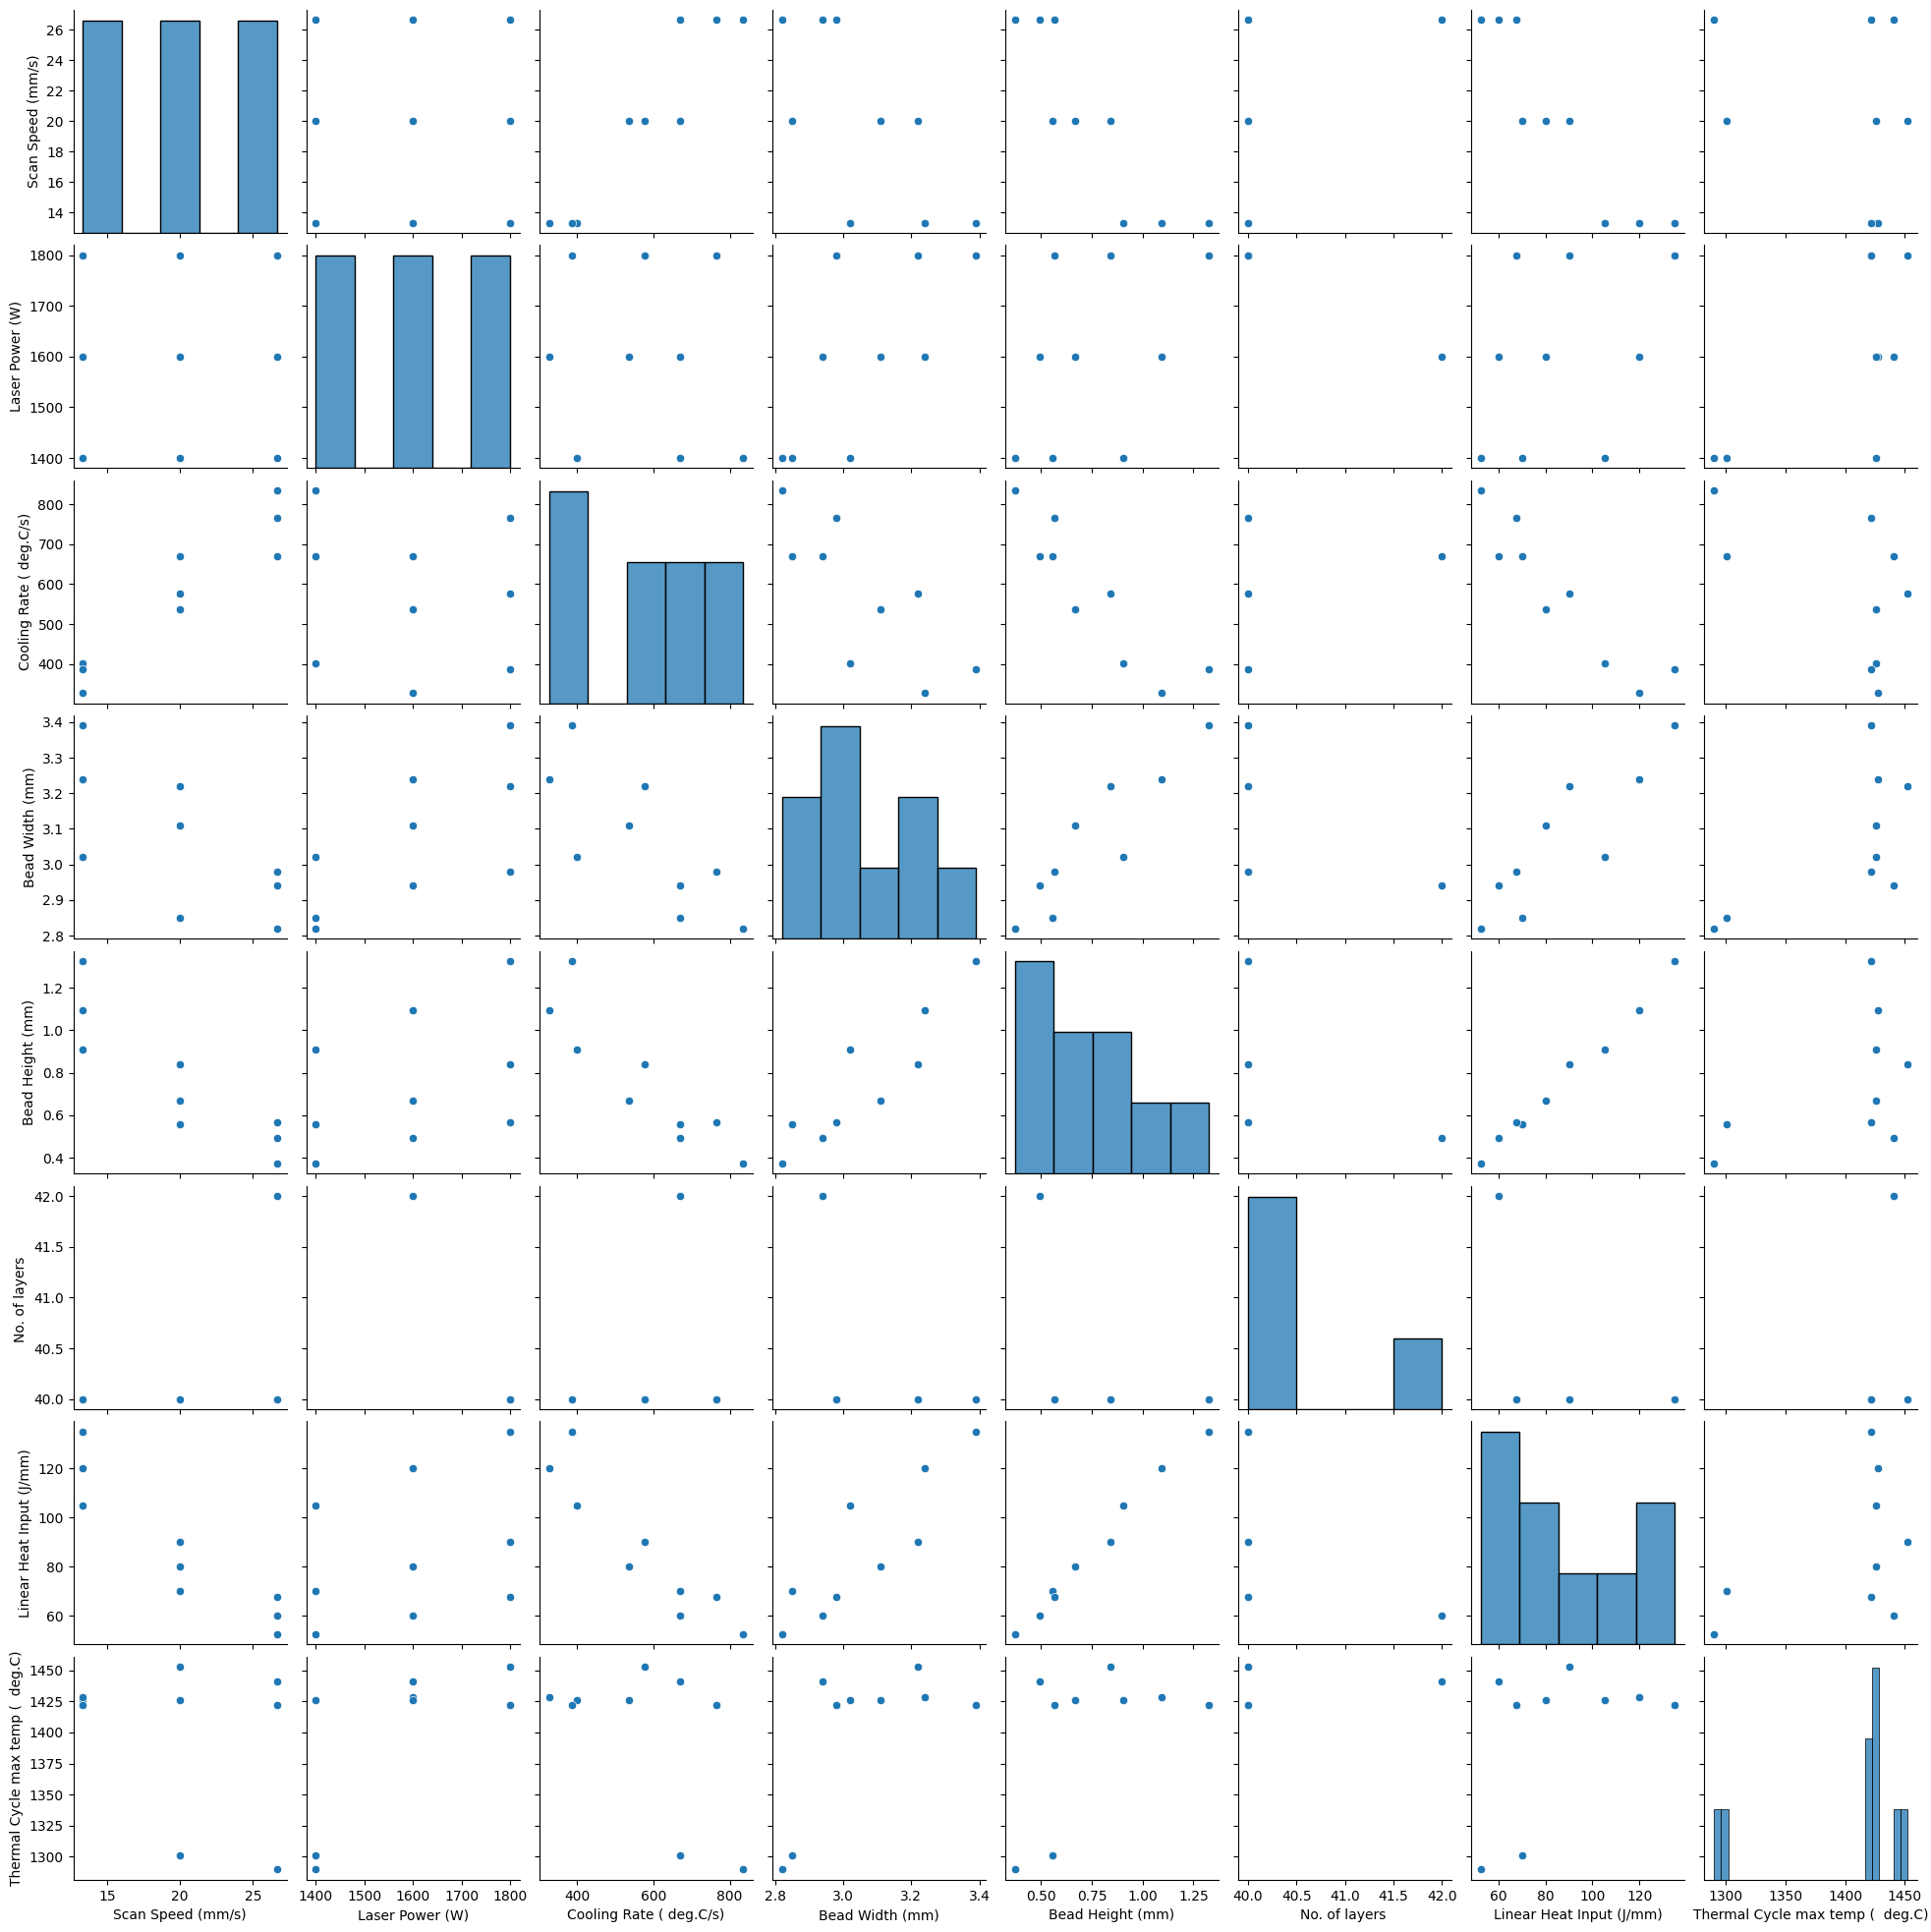

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
print(features_df.isnull().sum())
print(targets_df.isnull().sum())

# Visualize feature distributions
sns.pairplot(features_df)
plt.show()

In [ ]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                            Feature  Importance
1                   Laser Power (W)    0.530504
7  Thermal Cycle max temp (  deg.C)    0.123929
3                   Bead Width (mm)    0.087288
5                    No. of layers     0.083734
2           Cooling Rate ( deg.C/s)    0.068570
4                  Bead Height (mm)    0.055670
6          Linear Heat Input (J/mm)    0.034173
0                 Scan Speed (mm/s)    0.016131
